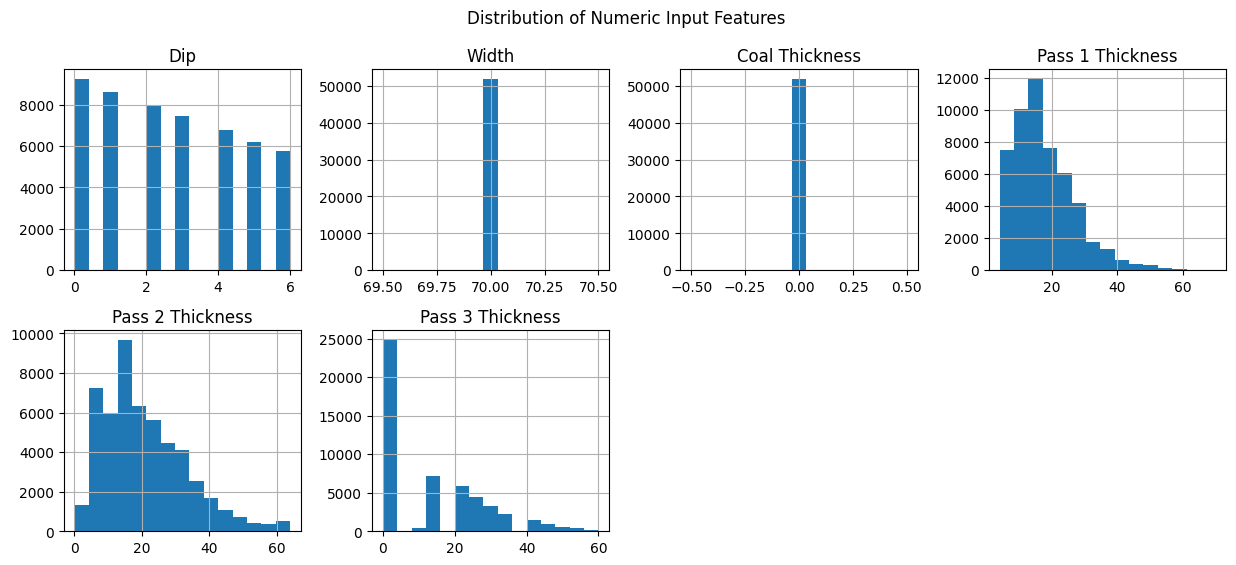

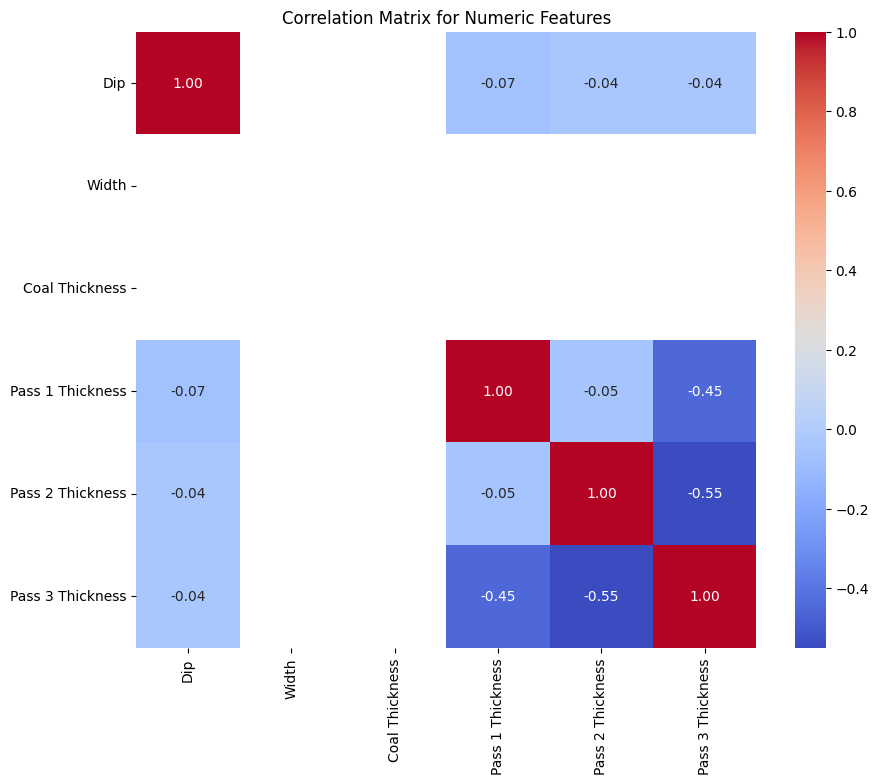

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('Dragline Factors V1.xlsx')

#Define input and output columns if known
input_cols = df.columns[0:8]  # Update this as necessary
output_cols = df.columns[32:39]  # Update this as necessary

#Visualize initial data distributions for numeric input features only
numeric_cols = df[input_cols].select_dtypes(include=[np.number])
numeric_cols.hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.suptitle('Distribution of Numeric Input Features')
plt.show()

#correlation matrix heatmap for numeric columns only
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()



In [2]:
#Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), input_cols[2:]),  # Normalize numerical data
        ('cat', OneHotEncoder(), ['Dragline', 'Method'])  # Encode categorical data
    ])

X = preprocessor.fit_transform(df[input_cols])
y = df[output_cols].values
dump(preprocessor, 'preprocessor.joblib')

#Prep for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [3]:
#Model architecture setup
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(output_dim, activation='linear')  # Adjust based on the nature of the output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

#Cross-validation
fold_no = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(X_train.shape[1], y_train.shape[1])
    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test))

    fold_no += 1


c:\Users\Praty\Desktop\DF_interface\dragline_factors\my-app\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training on fold 1...
Epoch 1/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0708 - mae: 0.1132 - val_loss: 0.0034 - val_mae: 0.0337
Epoch 2/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0029 - mae: 0.0312 - val_loss: 0.0022 - val_mae: 0.0248
Epoch 3/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0021 - mae: 0.0258 - val_loss: 0.0035 - val_mae: 0.0360
Epoch 4/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0020 - mae: 0.0259 - val_loss: 0.0017 - val_mae: 0.0231
Epoch 5/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0015 - mae: 0.0226 - val_loss: 0.0013 - val_mae: 0.0202
Epoch 6/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0013 - mae: 0.0214 - val_loss: 0.0013 - val_mae: 0.0216
Epoch 7/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0010 - mae: 0.0187 - val_loss: 0.0011 - val_mae: 0.0198
Epoch 8/50
1298/1298 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - mae: 0.0186 - val_loss: 0.0012 - val_mae: 0.0197
Epoch 9/50
1298/12

325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8724e-04 - mae: 0.0105
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\Praty\Desktop\DF_interface\dragline_factors\my-app\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Loss: 0.00030020816484466195, Test MAE: 0.008986790664494038
Root Mean Squared Error: 0.014983494579366713
R-squared: 0.9987580899614922


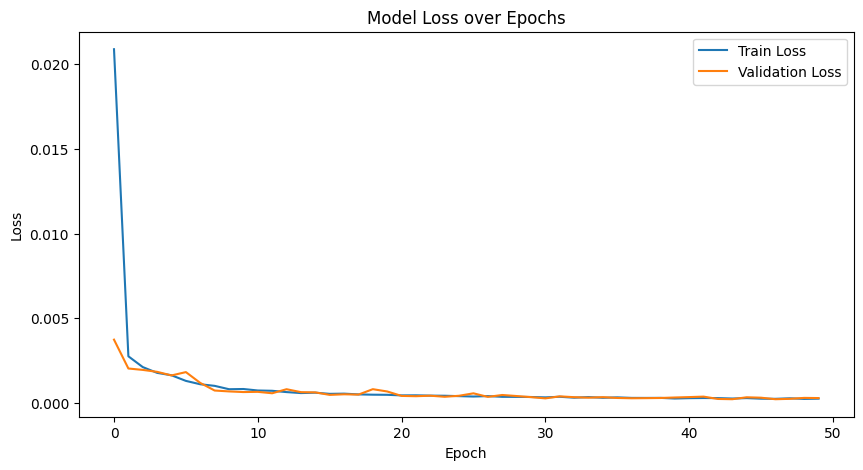

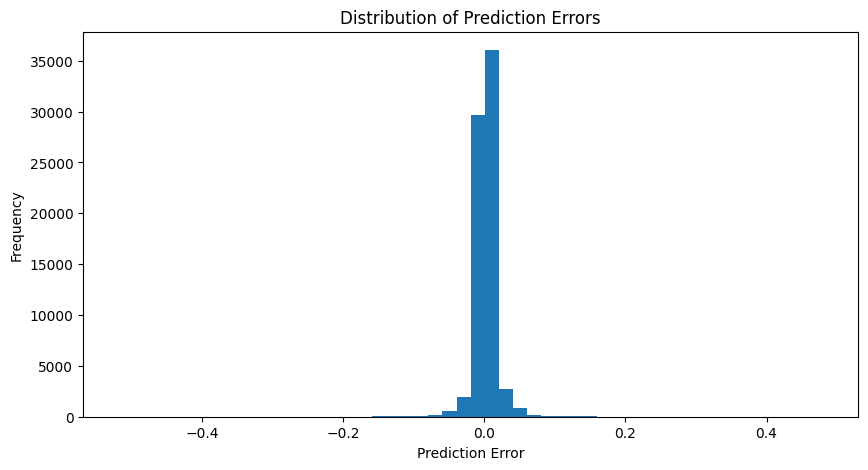

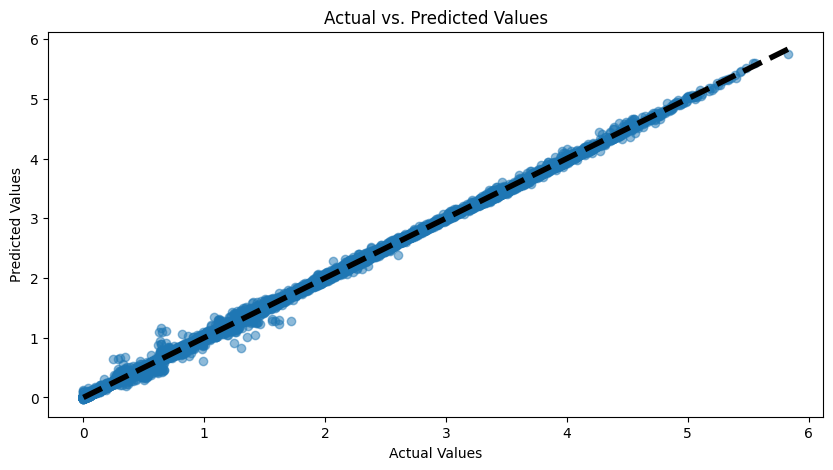

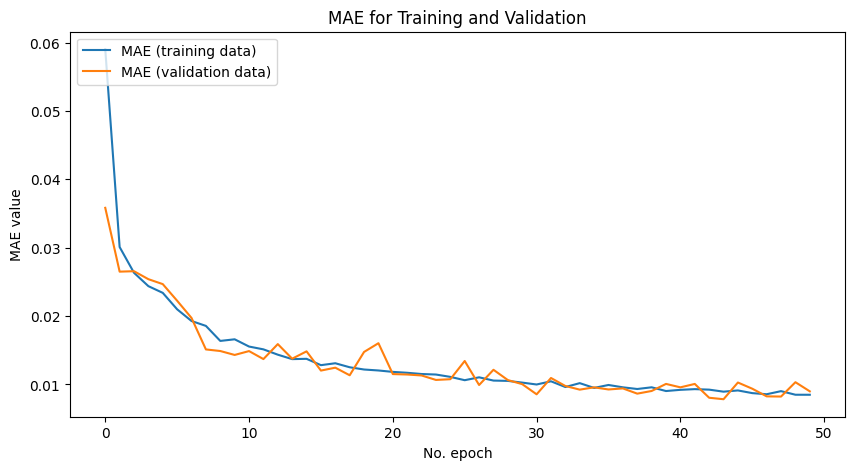

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

#Model Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

#Prediction should have the same shape as y_test for calculation
if predictions.shape != y_test.shape:
    predictions = predictions.reshape(y_test.shape)

rmse = mean_squared_error(y_test, predictions, squared=False)
r_squared = r2_score(y_test, predictions)

print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r_squared}')

#Plotting training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Error Histogram
errors = y_test - predictions
plt.figure(figsize=(10, 5))
plt.hist(errors.flatten(), bins=50)  #Flattening errors for histogram
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

#Actual vs. Predicted Values Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.5)  #Flattening for scatter plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

#learning Curves for MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('MAE for Training and Validation')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
